# Aufgabe 4

## Datasets

- **sp500_companies.csv**: Enthält Informationen über Unternehmen, die im S&P 500 gelistet sind, einschliesslich Börse, Symbols, Namen (Kurz- und Langbezeichnung), Sektors, Branche,  Kurses,  Marktkapitalisierung, EBITDA, Umsatzwachstums, Standorts, Anzahl der Vollzeitbeschäftigten, Zusammenfassung ihrer Geschäftstätigkeit und Gewichtung im Index.

- **sp500_index.csv**:** Verfolgt die tägliche Performance des S&P 500 Index, wobei jede Zeile ein Datum und den entsprechenden Indexwert an diesem Datum darstellt.

- **sp500_stocks.csv**: Enthält detaillierte Daten zur Aktienperformance der Unternehmen im S&P 500, einschliesslich des bereinigten Schlusskurses, des Schlusskurses, des Höchst- und Tiefstkurses, der Eröffnungskurse und des Volumens für jeden Handelstag.

## Efficient Frontier

Die "Effiziente Grenze" (Efficient Frontier) ist ein Konzept aus der MPT, das die Menge aller Portfolios darstellt, die die höchste erwartete Rendite für ein gegebenes Risikoniveau (oder die niedrigste Varianz für eine gegebene erwartete Rendite) bieten. Portfolios, die auf der Effizienten Grenze liegen, gelten als optimal, da sie das beste Risiko-Ertrags-Verhältnis bieten.

Der folgende Code bereitet die Daten vor, indem er tägliche Renditen für ausgewählte Aktien aus dem S&P 500-Datensatz berechnet. Die Organisation der Daten in einer Pivot-Tabelle ermöglicht eine effiziente Analyse der Renditen der ausgewählten Aktien, was für die Bestimmung der Effizienten Grenze und des Sharpe-Verhältnisses notwendig ist.

In [1]:
import pandas as pd
import numpy as np

# Load stock data
sp500_stocks = pd.read_csv('../../Data/sp500_stocks/sp500_stocks.csv')

# Convert date string to a date object and sort the data
sp500_stocks['Date'] = pd.to_datetime(sp500_stocks['Date'])
sp500_stocks.sort_values(by=['Symbol', 'Date'], inplace=True)

# Calculate daily returns for each stock in the dataset, explicitly specifying fill_method=None
sp500_stocks['Daily Returns'] = sp500_stocks.groupby('Symbol')['Close'].pct_change(fill_method=None)

# Preparing data for Efficient Frontier and Sharpe Ratio calculation
# Select stocks for analysis
selected_stocks = ['AAPL', 'EXC', 'GOOGL', 'AMZN', 'KMX']  # Example stocks
filtered_data = sp500_stocks[sp500_stocks['Symbol'].isin(selected_stocks)]

# Pivot table to organize daily returns for selected stocks
pivot_returns = filtered_data.pivot_table(values='Daily Returns', index='Date', columns='Symbol')

# Clean the data by removing missing values
pivot_returns.dropna(inplace=True)
print(pivot_returns.head())

Symbol          AAPL      AMZN       EXC     GOOGL       KMX
Date                                                        
2010-01-05  0.001729  0.005900 -0.016367 -0.004404  0.005838
2010-01-06 -0.015906 -0.018116  0.006032 -0.025209  0.012852
2010-01-07 -0.001849 -0.017013  0.003308 -0.023280 -0.009415
2010-01-08  0.006648  0.027077 -0.004739  0.013331  0.004545
2010-01-11 -0.008821 -0.024041  0.011594 -0.001512 -0.014809


Als Nächstes werden wir Portfolio-Renditen, Portfolio-Volatilitäten und das Sharpe-Verhältnis für eine Reihe von zufällig generierten Portfolios berechnen, um die Effiziente Grenze zu visualisieren.

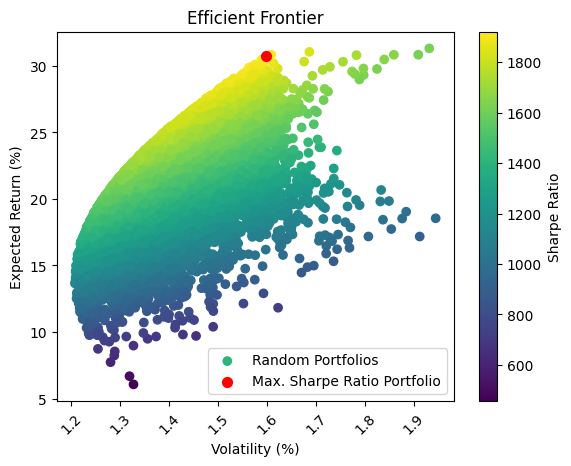

In [12]:
import matplotlib.pyplot as plt

# Assuming pivot_returns is already prepared from the previous snippet

# Risk-free rate for Sharpe ratio calculation (assumed value)
risk_free_rate = 0.01 # Here i.e. 1%

# Number of random portfolios to generate
num_portfolios = 30000
num_stocks = len(pivot_returns.columns)

# Arrays to store results
portfolio_returns = np.zeros(num_portfolios)
portfolio_volatilities = np.zeros(num_portfolios)
sharpe_ratios = np.zeros(num_portfolios)
weight_array = np.zeros((num_portfolios, num_stocks))

# Calculate expected returns and covariance matrix for the available selected stocks
expected_returns = pivot_returns.mean()

# Annualize the mean daily returns and convert to percent
annualized_returns = ((1 + expected_returns) ** 252 - 1) * 100  # Assumes 252 Trading days

cov_matrix = pivot_returns.cov()

for i in range(num_portfolios):
    # Random weights for stocks in the portfolio
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
    weight_array[i, :] = weights
    
    # Calculate portfolio return (in percent) and volatility (already in percent)
    portfolio_returns[i] = np.dot(weights, annualized_returns)  # This is now in percent because annualized_returns is in percent
    portfolio_volatilities[i] = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * 100  # Convert volatility to percent
    
    # Calculate Sharpe ratio, note: no change needed here as both returns and volatility are in percent
    sharpe_ratios[i] = (portfolio_returns[i] - risk_free_rate) / (portfolio_volatilities[i] / 100)

# Find the portfolio with the highest Sharpe ratio
max_sharpe_idx = sharpe_ratios.argmax()

# Adjust the plotting section if needed
plt.scatter(portfolio_volatilities, portfolio_returns, c=sharpe_ratios, cmap='viridis', label='Random Portfolios')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(portfolio_volatilities[max_sharpe_idx], portfolio_returns[max_sharpe_idx], color='red', s=50, label='Max. Sharpe Ratio Portfolio')
plt.xlabel('Volatility (%)')
plt.ylabel('Expected Return (%)')
plt.title('Efficient Frontier')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [13]:
# Output the optimal portfolio weights according to Sharpe ratio
optimal_weights = weight_array[max_sharpe_idx]

# Display the optimal weights
print("Optimal Portfolio Weights according to Sharpe Ratio:")
for stock, weight in zip(pivot_returns.columns, optimal_weights):
    print(f"{stock}: {weight*100:.2f}%")

Optimal Portfolio Weights according to Sharpe Ratio:
AAPL: 58.98%
AMZN: 35.68%
EXC: 0.60%
GOOGL: 1.42%
KMX: 3.32%


Die Gewichte ändern sich bei jedem Durchlauf der Simulation aufgrund der zufälligen Generierung von Portfolio-Gewichten im Prozess der Erstellung einer breiten Palette möglicher Portfolios:

- Zufällige Gewichtungsgenerierung: Bei jeder Iteration, die die Portfolios generiert, werden den Aktien im Portfolio zufällig Gewichte zugewiesen. Diese Zufälligkeit ist grundlegend für den Monte-Carlo-Simulationsansatz, der hier verwendet wird, wo das Ziel ist, eine breite Palette möglicher Portfoliokombinationen zu erkunden, um diejenigen mit den besten Leistungskennzahlen (bzw. Sharpe-Verhältnis) zu identifizieren.

- Grosser Lösungsraum: Der "Raum" möglicher Gewichtungskombinationen ist riesig. Selbst mit 30'000 Portfolios deckt die Simulation nur einen Bruchteil der möglichen Gewichtungskonfigurationen ab. Jeder Durchlauf der Simulation probiert verschiedene Teile dieses Raums aus, was zu Variabilität im identifizierten optimalen Portfolio in jedem Durchlauf führt.

- Sensibilität gegenüber Gewichtsänderungen: Portfoliokennzahlen wie erwartete Rendite, Volatilität und das Sharpe-Verhältnis können empfindlich auf Änderungen in den Gewichtungszuweisungen reagieren, besonders in Portfolios mit diversen Aktienleistungen. Kleine Änderungen in den Gewichten können dazu führen, dass verschiedene Portfolios als "optimal" basierend auf dem Sharpe-Verhältnis identifiziert werden.

- Einfluss der Zufälligkeit: Da der Prozess auf Zufälligkeit beruht, gibt es keine Garantie, dass aufeinanderfolgende Durchläufe auf die gleichen oder sogar ähnliche Gewichtungszuweisungen für das optimale Portfolio konvergieren. Die Zufälligkeit hilft, den Lösungsraum zu erkunden, führt aber auch zur Variabilität in den Ergebnissen.

**Frage: Wieso ist Apple aber trotzdem oft (wenn die Simulation X-mal durchgelaufen wird) hochprozentig vertreten?**

## Sharpe Ratio

Angenommen, *pivot_returns* enthält die täglichen Renditen für eine Auswahl von Aktien. Wir berechnen die Sharpe-Ratio für ein hypothetisches Portfolio aus diesen Aktien, indem wir die durchschnittliche Rendite, die Volatilität und das Sharpe-Verhältnis auf einer annualisierten Basis berechnen.

In [14]:
# Assumed annual risk-free rate
risk_free_rate_annual = 0.01 # 1%

# Calculating average daily return and daily standard deviation for each stock
average_daily_returns = pivot_returns.mean()
daily_std_dev = pivot_returns.std()

# Assuming equal weights for each stock in the portfolio
weights = np.array([1/len(pivot_returns.columns)] * len(pivot_returns.columns))

# Calculating daily portfolio return and volatility
portfolio_daily_return = np.dot(average_daily_returns, weights)
portfolio_daily_volatility = np.sqrt(np.dot(weights.T, np.dot(pivot_returns.cov(), weights)))

# Converting daily values to annual values
annualized_return = (1 + portfolio_daily_return) ** 252 - 1
annualized_volatility = portfolio_daily_volatility * np.sqrt(252)

# Calculating annual Sharpe Ratio
sharpe_ratio_annual = (annualized_return - risk_free_rate_annual) / annualized_volatility

print(f"Annualized Portfolio Return: {annualized_return*100:.2f}%")
print(f"Annualized Portfolio Volatility: {annualized_volatility*100:.2f}%")
print(f"Annual Sharpe Ratio: {sharpe_ratio_annual:.2f}")

Annualized Portfolio Return: 20.23%
Annualized Portfolio Volatility: 21.03%
Annual Sharpe Ratio: 0.91


Sharpe Ratio mit hypothetischen Portfolios:

In [15]:
# Assumed annual returns and volatilities
portfolio_a_returns = 0.08  # 8%
portfolio_a_volatility = 0.1  # 10%

portfolio_b_returns = 0.12  # 12%
portfolio_b_volatility = 0.15  # 15%

# Risk-free rate (assumed 2% annually)
risk_free_rate_annual = 0.02

# Sharpe-Ratio calculation
sharpe_ratio_a = (portfolio_a_returns - risk_free_rate_annual) / portfolio_a_volatility
sharpe_ratio_b = (portfolio_b_returns - risk_free_rate_annual) / portfolio_b_volatility

print(f"Sharpe Ratio Portfolio A: {sharpe_ratio_a:.2f}")
print(f"Sharpe Ratio Portfolio B: {sharpe_ratio_b:.2f}")

# Descision based on Sharpe-Ratio
if sharpe_ratio_a > sharpe_ratio_b:
    print("Portfolio A provides a better risk-adjusted Performance.")
else:
    print("Portfolio B provides a better risk-adjusted Performance.")

Sharpe Ratio Portfolio A: 0.60
Sharpe Ratio Portfolio B: 0.67
Portfolio B provides a better risk-adjusted Performance.


# Übungen

### Übung 1: Berechnung des Sharpe-Verhältnisses
Gegeben sind zwei Portfolios mit folgenden erwarteten Jahresrenditen und Volatilitäten:

Portfolio A: Erwartete Rendite von 8%, Volatilität von 10%
Portfolio B: Erwartete Rendite von 12%, Volatilität von 15%
Die risikofreie Rate beträgt 2%. Berechnen Sie das Sharpe-Verhältnis für beide Portfolios und diskutieren Sie, welches Portfolio eine bessere risikobereinigte Rendite bietet.

In [9]:
# Your code here

### Übung 2: Erstellung eines hypothetischen Portfolios
Erstellen Sie ein hypothetisches Portfolio aus drei Aktien Ihrer Wahl. Nehmen Sie an, dass die erwarteten Jahresrenditen 10%, 12% und 14% betragen und die Volatilitäten 10%, 15% und 20%. Die Gewichtungen der Aktien im Portfolio betragen 30%, 40% und 30%. Berechnen Sie die erwartete Rendite und die Volatilität des Portfolios. Nutzen Sie die risikofreie Rate von 2% zur Berechnung des Sharpe-Verhältnisses.

In [10]:
# Your code here

### Übung 3: Analyse der Effizienten Grenze
Betrachten Sie vier hypothetische Portfolios mit folgenden Eigenschaften:

- Portfolio 1: Erwartete Rendite von 6%, Volatilität von 8%
- Portfolio 2: Erwartete Rendite von 8%, Volatilität von 12%
- Portfolio 3: Erwartete Rendite von 10%, Volatilität von 15%
- Portfolio 4: Erwartete Rendite von 12%, Volatilität von 20%

Skizzieren Sie auf Papier eine mögliche Effiziente Grenze, die diese Portfolios einschliesst. Markieren Sie die Portfolios auf Ihrer Skizze und identifizieren Sie das Portfolio mit dem höchsten Sharpe-Verhältnis, ausgehend von einer risikofreien Rate von 2%.